In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Loading

In [2]:
df = pd.read_excel('premiums_young_with_gr.xlsx')

In [3]:
df.shape

(20096, 14)

In [4]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


# Data Cleaning & EDA

In [5]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

### Making the column names consistent 

In [6]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [7]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

### Handling Null values

In [8]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [9]:
# Droping Null entries since the number of null entries are small

df.dropna(inplace=True)

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


we can identify outliers in age, number of dependents and income

### Handling Outliers

In [11]:
numerical_columns = df.select_dtypes(['int64', 'float64']).columns

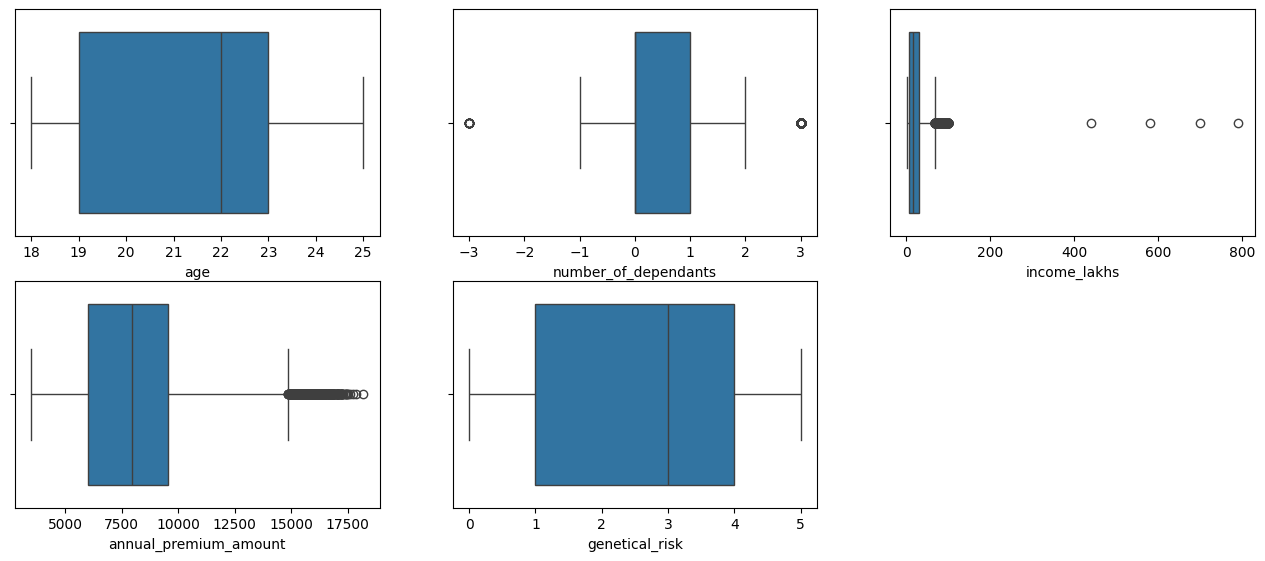

In [14]:
# Box plot to visualize outliers

plt.figure(figsize=(16,10))
for idx, col in enumerate(numerical_columns):
    plt.subplot(3,3,idx+1)
    sns.boxplot(data=df, x=col)
plt.show()  

In [15]:
# Number of dependents cannot be negative

df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [16]:
# Conisder max age to be 100 

df[df['age'] > 100].shape[0]

0

In [17]:
# Dropping entries with age > 100

df = df[df['age'] <= 100]
df.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

In [18]:
def get_iqr_range(col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [19]:
lower, upper = get_iqr_range('income_lakhs')
lower, upper

# Here is ther upper bound for income is 67 lpa

(-31.5, 68.5)

In [20]:
income_upper_bound = df['income_lakhs'].quantile(0.999)

In [21]:
df[df['income_lakhs'] > income_upper_bound].shape[0]

4

In [22]:
# Conside 1 Cr as upper bound for income per year and Droping income outliers

df = df[df['income_lakhs'] <= income_upper_bound]

In [23]:
df.income_lakhs.describe()

count    20086.000000
mean        22.390371
std         21.732062
min          1.000000
25%          6.000000
50%         16.000000
75%         31.000000
max        100.000000
Name: income_lakhs, dtype: float64

### Distribution of Numerical columns

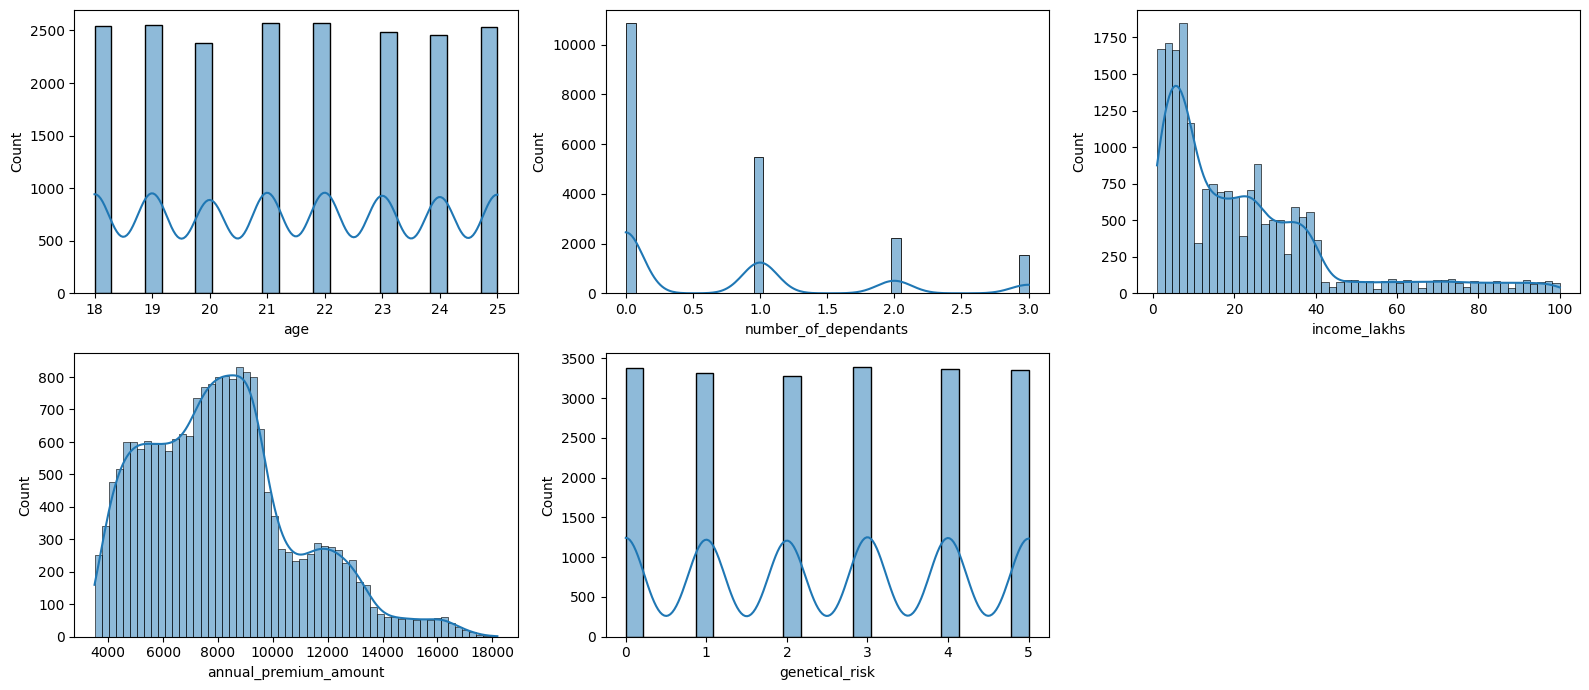

In [25]:
plt.figure(figsize=(16,10))
for idx, col in enumerate(numerical_columns):
    plt.subplot(3,3,idx+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show() 

From the distribution we can understand that the columns age, income, annual premium are right skewed

In [26]:
categorical_columns = df.select_dtypes('object').columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [27]:
# Exploring the categorical values

for col in categorical_columns:
    print(f"{col} - {df[col].unique()}")

gender - ['Male' 'Female']
region - ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status - ['Unmarried' 'Married']
bmi_category - ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status - ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status - ['Self-Employed' 'Freelancer' 'Salaried']
income_level - ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history - ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan - ['Silver' 'Bronze' 'Gold']


In [28]:
# The smoking status is not uniform

df['smoking_status'] = df['smoking_status'].replace({
                        'Smoking=0': 'No Smoking',
                        'Does Not Smoke': 'No Smoking',
                        'Not Smoking': 'No Smoking'
                    })
df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Distribution of Categorical columns

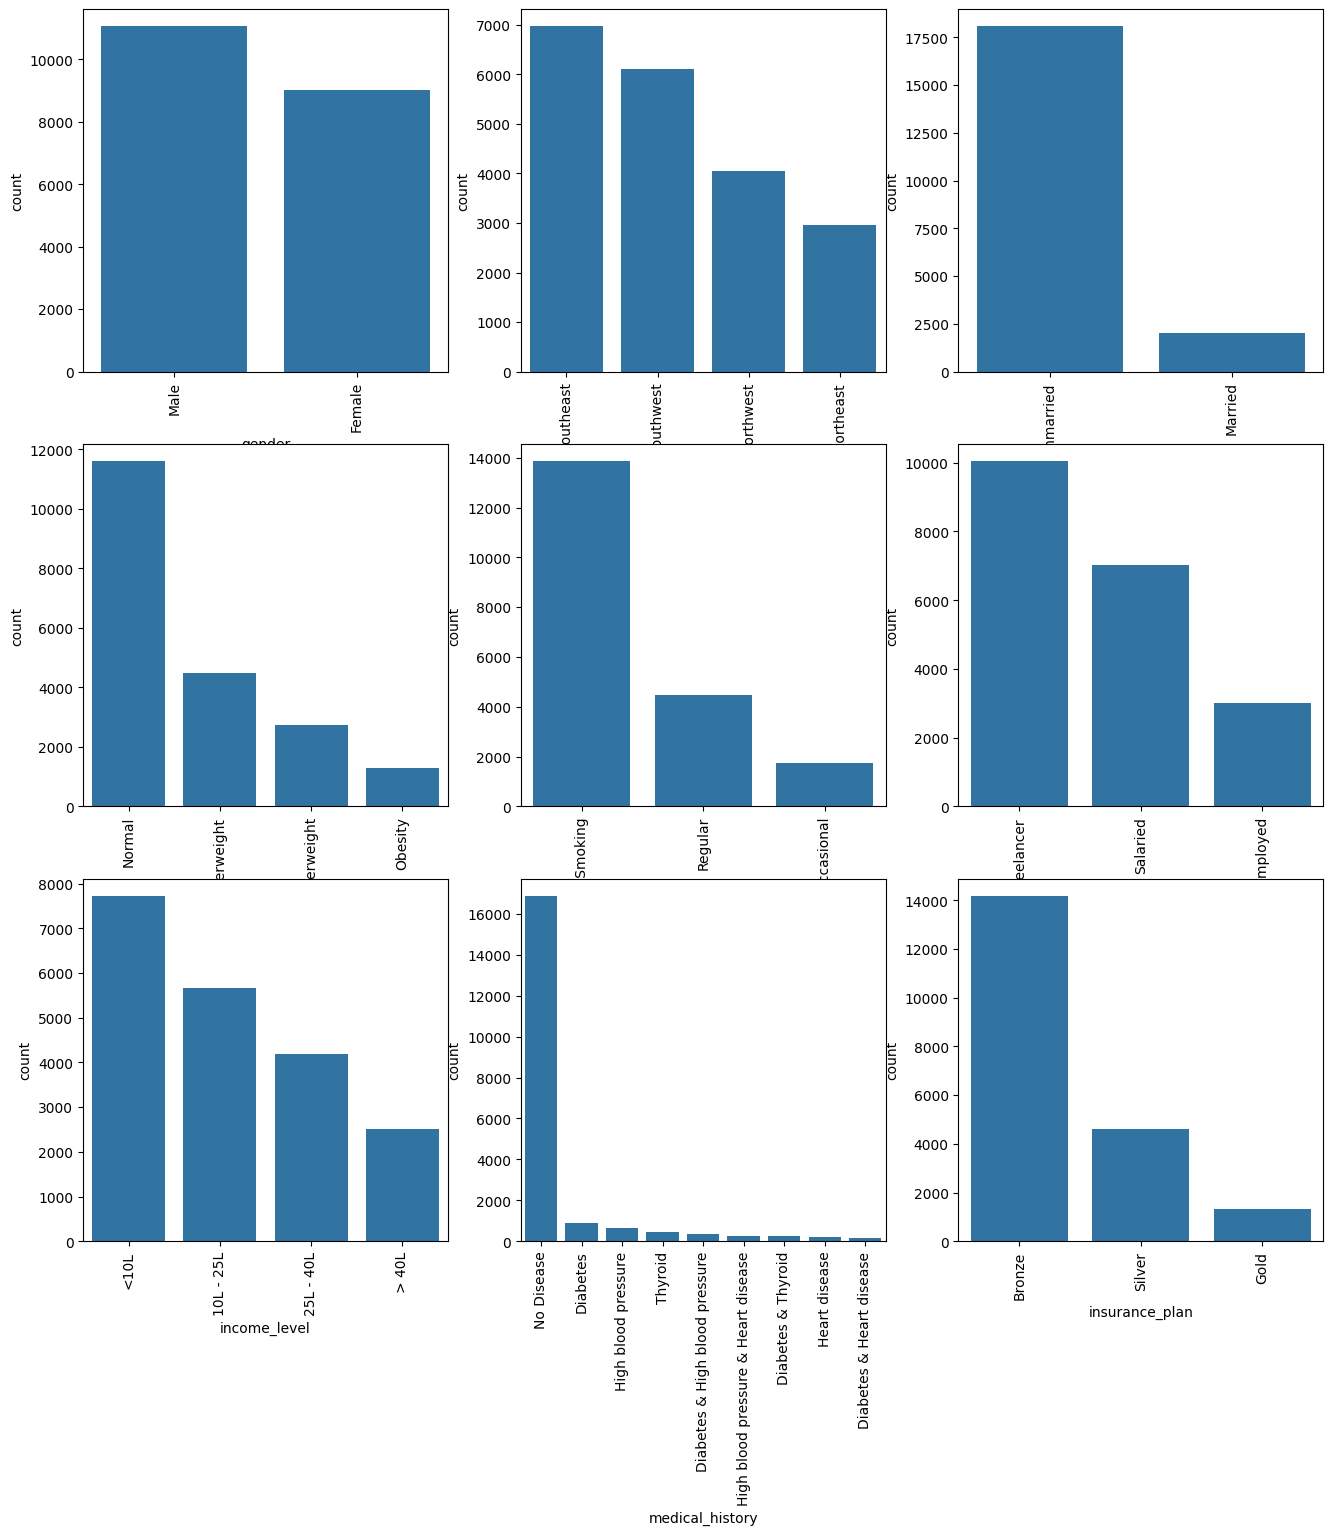

In [31]:
plt.figure(figsize=(16,16))
for idx, col in enumerate(categorical_columns):
    plt.subplot(3,3,idx+1)
    sns.barplot(df[col].value_counts())
    plt.xticks(rotation=90)
plt.show()

In [32]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


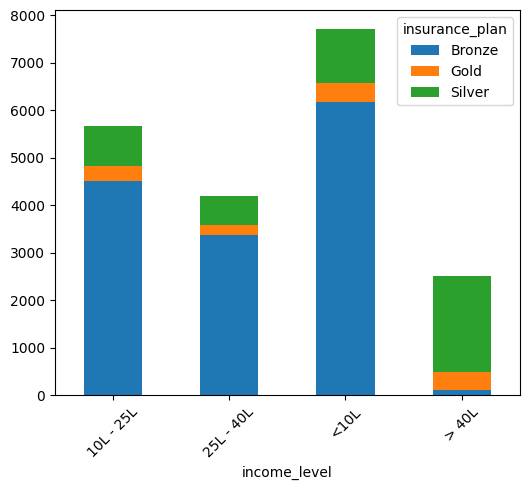

In [33]:
crosstab.plot(kind='bar', stacked=True, figsize=(6, 5))
plt.xticks(rotation=45)
plt.show()

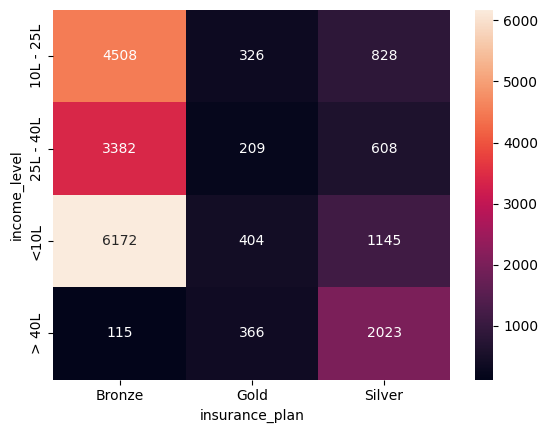

In [34]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

# Feature Engineering

In [35]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [36]:
df.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [37]:
df['medical_history'] = df['medical_history'].str.lower()

In [38]:
# Max a person has 2 disease so extracting into seprate columns

df[['disease1', 'disease2']] = df.medical_history.str.split(' & ', expand=True)

df['disease2'] = df['disease2'].fillna('none')

In [39]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df['total_risk_score'] = df['disease1'].map(risk_scores) + df['disease2'].map(risk_scores)

In [40]:
df['insurance_plan'] = df['insurance_plan'].map({"Bronze":1, "Silver":2, "Gold":3})

In [41]:
df['income_level'] = df['income_level'].map({"<10L":1, "10L - 25L":2, "25L - 40L":3, "> 40L":4})

In [42]:
cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,high blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,no disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0


In [43]:
# drop text columns

df.drop(columns=['medical_history', 'disease1', 'disease2'], inplace=True)

In [44]:
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,6,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0,0,1,0,0,1,0,0,1,0,0,0,0


In [45]:
cols_to_norm = ['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan', 'total_risk_score', 'genetical_risk']
scaler = MinMaxScaler()
df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])
df.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,4,0.989899,0.5,13365,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,1,0.020202,0.5,11050,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,4,0.969697,0.5,11857,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,2,0.141414,0.0,5684,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,2,0.131313,0.0,5712,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


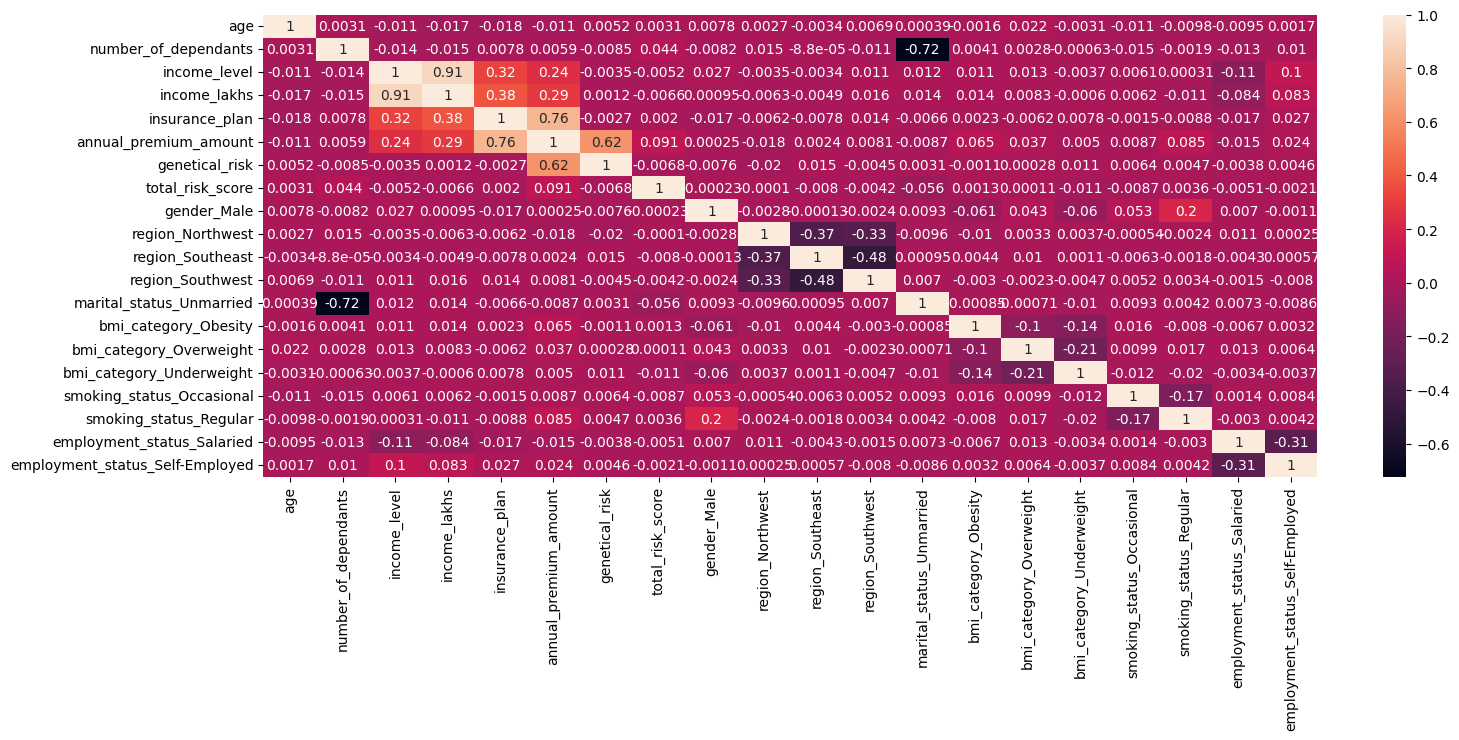

In [46]:
corr = df.corr()
plt.figure(figsize=(17,6))
sns.heatmap(corr, annot=True)
plt.show()

In [47]:
def get_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Features'] = data.columns
    vif_df['Values'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [48]:
get_vif(df.drop('annual_premium_amount', axis=1))

,Features,Values
0,age,3.181997
1,number_of_dependants,2.117793
2,income_level,24.758868
3,income_lakhs,10.923404
4,insurance_plan,1.590223
5,genetical_risk,2.998987
6,total_risk_score,1.156015
7,gender_Male,2.331474
8,region_Northwest,2.185969
9,region_Southeast,3.042592


In [49]:
get_vif(df.drop(['annual_premium_amount', 'income_level'], axis=1))

,Features,Values
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,total_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


removing column - income_level since it has a high VIF value.

In [50]:
df.drop('income_level', axis=1, inplace=True)

In [51]:
X = df.drop('annual_premium_amount', axis=1)
y = df['annual_premium_amount']

# Model Training

### Model Training - Linear Regression

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) 

model = LinearRegression()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

train_score, test_score

(0.9883565643058372, 0.9887276849857888)

In [53]:
model.intercept_

np.float64(3983.20403304918)

In [54]:
model.coef_

array([-2.97015209e+00,  1.82602965e+01, -1.24456960e+01,  7.00089756e+03,
        4.99912131e+03,  1.11139323e+03,  6.90506110e+00,  3.93620243e+00,
        3.50949985e-01,  5.79389341e+00,  9.94412269e+00,  8.10818811e+02,
        4.01400727e+02,  1.05992190e+02,  2.02982613e+02,  6.09345255e+02,
       -1.04898874e+00, -2.80618004e+00])

In [55]:
X_train.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [56]:
feature_importance = pd.DataFrame(model.coef_, index=X_train.columns, columns=['value'])
feature_importance = feature_importance.sort_values(by='value', ascending=True)

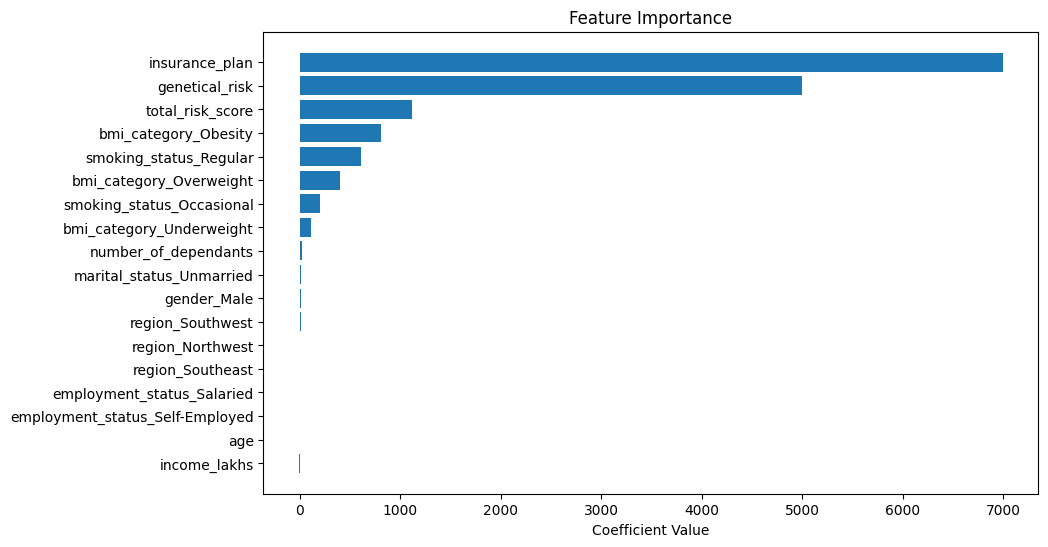

In [57]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance['value'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()

In [58]:
y_pred = model.predict(X_test)

r2 = r2_score(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

R-squared: 0.988664514294118
Mean Squared Error: 85217.06575163029
Mean Absolute Error: 250.47940168296913


In [60]:
best_model = model

# Error Analysis

In [61]:
y_pred = best_model.predict(X_test)

diff = y_pred - y_test
diff_prc = diff*100/y_test

error_df = pd.DataFrame({
            "actual": y_test,
            "pred": y_pred,
            "difference": diff,
            "diff_prc": diff_prc
        })

In [62]:
error_df.head()

,actual,pred,difference,diff_prc
12774,6238,6120.188347,-117.811653,-1.888613
14758,9462,9602.999537,140.999537,1.490166
13205,5152,5612.557988,460.557988,8.939402
14278,6988,7421.416276,433.416276,6.202294
19351,4917,5108.709192,191.709192,3.898906


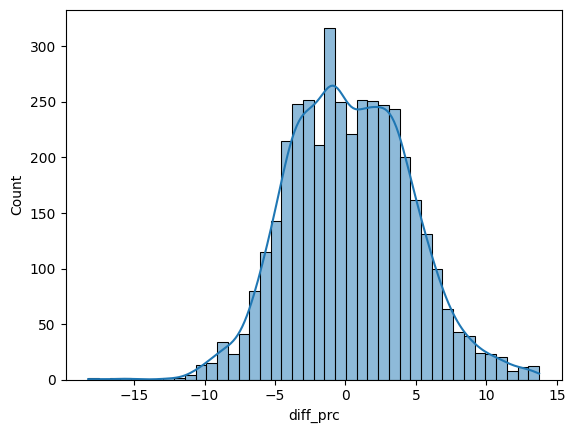

In [63]:
sns.histplot(error_df.diff_prc, kde=True)
plt.show()

In [64]:
extreme_error_df = error_df[np.abs(error_df.diff_prc) > 10] # difference >10%

In [65]:
extreme_error_pct = extreme_error_df.shape[0]*100/error_df.shape[0]
extreme_error_pct

2.190144350423096

only 2% error > 10%

In [70]:
extreme_error_df = error_df[np.abs(error_df.diff_prc) > 50] # difference >50%

extreme_error_pct = extreme_error_df.shape[0]*100/error_df.shape[0]
extreme_error_pct

0.0

No error > 50%

# Export Model

In [73]:
from joblib import dump

dump(best_model, "artifacts/model_young.joblib")

['artifacts/model_young.joblib']

In [75]:
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_norm
}

dump(scaler_with_cols, "artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']